In [1]:
import pandas as pd
import scanpy as sc

# Load the dropout matrix (rows: genes, columns: cells) and immediately transpose
counts = pd.read_csv('..\..\data\S500_O\symsim_true_counts_20000genes_500cells_complex.csv', index_col=0)

# Now counts has rows=cells, cols=genes, just like Scanpy expects
adata = sc.AnnData(counts)

# Load your integer-indexed labels
labels = pd.read_csv(
    '..\..\data/S500_O/symsim_labels_20000genes_500cells_complex.csv',
    index_col=0
)

# If your cell barcodes come in as "X1","X2",… strip off the "X" and cast to int
adata.obs.index = adata.obs.index.str.lstrip('X').astype(int)

# Pull in the class labels
adata.obs['cell_class'] = labels.reindex(adata.obs.index)['x'].astype(str)


c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [2]:
print("adata shape:", adata.shape)  # Should be (500, 20000)
print(adata.obs['cell_class'].value_counts(dropna=False))  # No NaNs!



adata shape: (500, 20000)
cell_class
4    63
5    63
6    63
7    63
1    62
2    62
3    62
8    62
Name: count, dtype: int64


In [3]:
print(adata)


AnnData object with n_obs × n_vars = 500 × 20000
    obs: 'cell_class'


In [4]:
import numpy as np
import scanpy as sc
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_score, adjusted_rand_score

metrics = {
    'euclidean': [],
    'manhattan': [],
    'minkowski_0.5': []
}

# Ensure you have Leiden labels for ARI
adata.obs['cell_class'] = adata.obs['cell_class'].astype(str)

for metric in ['euclidean', 'manhattan', 'minkowski_0.5']:
    trustworthiness_scores = []
    silhouette_scores = []
    ari_scores = []

    for i in range(10):
        print(f"Metric: {metric}, Run: {i+1}/10")

        if metric == 'minkowski_0.5':
            sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', metric='minkowski', metric_kwds={'p': 0.5})
        else:
            sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', metric=metric)

        sc.tl.umap(adata, random_state=None)
        sc.tl.leiden(adata, resolution=1.0, random_state=None)

        # Trustworthiness
        tw = trustworthiness(adata.X, adata.obsm['X_umap'], n_neighbors=15)
        trustworthiness_scores.append(tw)

        # Silhouette Score
        sil_score = silhouette_score(adata.obsm['X_umap'], adata.obs['cell_class'])
        silhouette_scores.append(sil_score)

        # Adjusted Rand Index (Leiden vs. known labels)
        ari = adjusted_rand_score(adata.obs['cell_class'], adata.obs['leiden'])
        ari_scores.append(ari)

    metrics[metric] = {
        'trustworthiness': trustworthiness_scores,
        'silhouette': silhouette_scores,
        'ari': ari_scores
    }

# Summary
for metric, results in metrics.items():
    print(f"\nSummary for {metric} (10 runs):")
    print(f"Mean Trustworthiness: {np.mean(results['trustworthiness']):.4f}, Variance: {np.var(results['trustworthiness']):.6f}")
    print(f"Mean Silhouette Score: {np.mean(results['silhouette']):.4f}, Variance: {np.var(results['silhouette']):.6f}")
    print(f"Mean ARI: {np.mean(results['ari']):.4f}, Variance: {np.var(results['ari']):.6f}")


Metric: euclidean, Run: 1/10


C:\Users\sofus\AppData\Local\Temp\ipykernel_10436\464222145.py:29: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0, random_state=None)


Metric: euclidean, Run: 2/10
Metric: euclidean, Run: 3/10
Metric: euclidean, Run: 4/10
Metric: euclidean, Run: 5/10
Metric: euclidean, Run: 6/10
Metric: euclidean, Run: 7/10
Metric: euclidean, Run: 8/10
Metric: euclidean, Run: 9/10
Metric: euclidean, Run: 10/10
Metric: manhattan, Run: 1/10
Metric: manhattan, Run: 2/10
Metric: manhattan, Run: 3/10
Metric: manhattan, Run: 4/10
Metric: manhattan, Run: 5/10
Metric: manhattan, Run: 6/10
Metric: manhattan, Run: 7/10
Metric: manhattan, Run: 8/10
Metric: manhattan, Run: 9/10
Metric: manhattan, Run: 10/10
Metric: minkowski_0.5, Run: 1/10


c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_graph.py:434: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  self._fit(X)
c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(


Metric: minkowski_0.5, Run: 2/10


c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_graph.py:434: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  self._fit(X)
c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(


Metric: minkowski_0.5, Run: 3/10


c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_graph.py:434: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  self._fit(X)
c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(


Metric: minkowski_0.5, Run: 4/10


c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_graph.py:434: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  self._fit(X)
c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(


Metric: minkowski_0.5, Run: 5/10


c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_graph.py:434: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  self._fit(X)
c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(


Metric: minkowski_0.5, Run: 6/10


c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_graph.py:434: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  self._fit(X)
c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(


Metric: minkowski_0.5, Run: 7/10


c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_graph.py:434: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  self._fit(X)
c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(


Metric: minkowski_0.5, Run: 8/10


c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_graph.py:434: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  self._fit(X)
c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(


Metric: minkowski_0.5, Run: 9/10


c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_graph.py:434: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  self._fit(X)
c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(


Metric: minkowski_0.5, Run: 10/10


c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_graph.py:434: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  self._fit(X)
c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(



Summary for euclidean (10 runs):
Mean Trustworthiness: 0.9414, Variance: 0.000003
Mean Silhouette Score: 0.1914, Variance: 0.000141
Mean ARI: 0.4730, Variance: 0.000004

Summary for manhattan (10 runs):
Mean Trustworthiness: 0.8847, Variance: 0.000012
Mean Silhouette Score: 0.6636, Variance: 0.000223
Mean ARI: 0.9529, Variance: 0.000000

Summary for minkowski_0.5 (10 runs):
Mean Trustworthiness: 0.7654, Variance: 0.000011
Mean Silhouette Score: 0.7593, Variance: 0.000147
Mean ARI: 0.9954, Variance: 0.000000


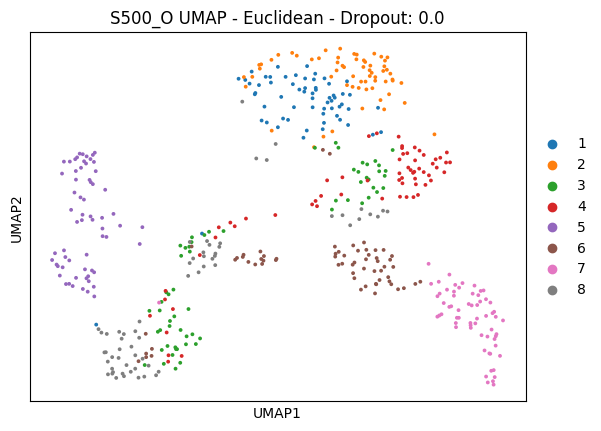

In [5]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', metric='euclidean')
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color="cell_class", size=30, title="S500_O UMAP - Euclidean - Dropout: 0.0")

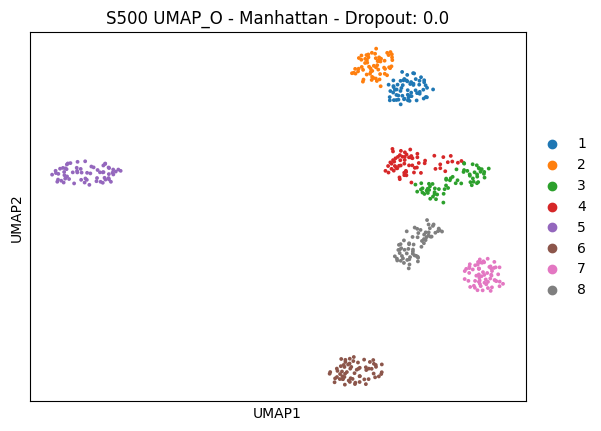

In [8]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', metric='manhattan')
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color="cell_class", size=30, title="S500 UMAP_O - Manhattan - Dropout: 0.0")

c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_graph.py:434: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  self._fit(X)
c:\Users\sofus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(


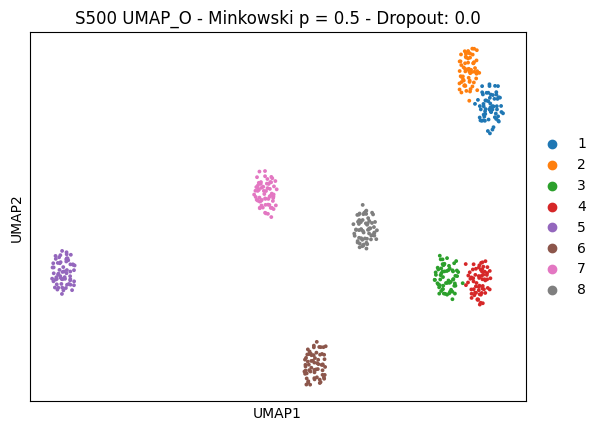

In [9]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', metric='minkowski', metric_kwds={'p': 0.5})
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color="cell_class", size=30, title="S500 UMAP_O - Minkowski p = 0.5 - Dropout: 0.0")